# Import Library

Import some needs library for Project

In [1]:
import tensorflow as tf
import pandas as pd
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil
import seaborn as sns


from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

from tensorflow.keras import models, layers
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Flatten, Reshape, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Dense, Concatenate, Add, Reshape, Dot, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array

from tensorflow.keras.applications import InceptionV3, ResNet152V2, VGG16, VGG19, MobileNet
from keras.applications.densenet import DenseNet201
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Preprocessing

## Setting Some Hyper-Parameters

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS   = 3

## Process Dataset with csv

In [3]:
#Loading the text file
df = pd.read_csv("/kaggle/input/Folds.csv")

In [4]:
#find duplicate rows across specific columns
duplicateRows = df[df.duplicated(['mag', 'grp', 'filename'])]

In [5]:
duplicateRows

fold  mag    grp                                           filename
7909      2  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
7910      2  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
7911      2  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
7912      2  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
7913      2  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
...     ...  ...    ...                                                ...
39540     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39541     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39542     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39543     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39544     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...

[24822 rows x 4 columns]

Where find out, from index 7909, data will be duplicate with differences Fold

In [6]:
dataset = df.iloc[:7909, :]

In [7]:
dataset.shape[0]

7909

In [8]:
#Renaming the column filename to path
dataset = dataset.rename(columns = {"filename":"path"})
#Show first 5 entries
dataset.head()

fold  mag    grp                                               path
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...

In [9]:
#Creating new columns for the filename, file location and labels from the path column
dataset['filename'] = dataset['path'].apply(lambda x:x.split("/")[-1])
dataset["label"] = dataset['path'].apply(lambda x: x.split("/")[3])
dataset["sublabel"] = dataset['path'].apply(lambda x: x.split("/")[5])
dataset['file_loc'] = dataset['label'] + "_" + dataset['filename']

**Encoding the class to integer**

Setting benign to 0
Setting Malignant to 1

In [10]:
#Encoding the class to integer
dataset['class'] = dataset['label'].apply(lambda x: 0 if x =='benign' else 1)

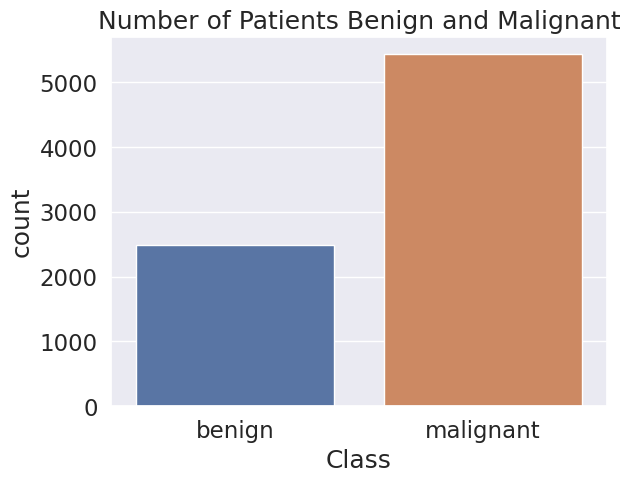

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'label' is a categorical column in your DataFrame
# If it's not, you might need to replace 'label' with the actual column name.
sns.set(font_scale=1.5)
sns.set_style("darkgrid")

# Assuming 'dataset' is your DataFrame
sns.countplot(data=dataset, x="label")
plt.xlabel("Class")
plt.title("Number of Patients Benign and Malignant")
plt.show()


In [12]:
print('Number of samples for each class: \n', dataset["class"].value_counts())

Number of samples for each class: 
 class
1    5429
0    2480
Name: count, dtype: int64


In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909 entries, 0 to 7908
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   fold      7909 non-null   int64 
 1   mag       7909 non-null   int64 
 2   grp       7909 non-null   object
 3   path      7909 non-null   object
 4   filename  7909 non-null   object
 5   label     7909 non-null   object
 6   sublabel  7909 non-null   object
 7   file_loc  7909 non-null   object
 8   class     7909 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 556.2+ KB


In [14]:
dataset['mag'].unique()

array([100, 200,  40, 400])

In [15]:
dataset_mag = dict()
dataset_mag[40] = dataset.loc[dataset['filename'].str.contains('40')]
dataset_mag[100] = dataset.loc[dataset['filename'].str.contains('100')]
dataset_mag[200] = dataset.loc[dataset['filename'].str.contains('200')]
dataset_mag[400] = dataset.loc[dataset['filename'].str.contains('400')]

In [16]:
def count_dataset(datasets):
    i = 0
    fig, ax = plt.subplots(2, 2, figsize=(20, 16)) 
    for key, value in datasets.items():
        i += 1
        plt.subplot(2,2, i)
        sns.set(font_scale=1.5)
        sns.set_style("darkgrid")
        # Assuming 'dataset' is your DataFrame
        sns.countplot(data=value, x="label")
        plt.xlabel("Class")
        plt.title("Benign and Malignant with Magnitude X" + str(key))
    plt.show()

In [ ]:
count_dataset(dataset_mag)

In [18]:
for key, value in dataset_mag.items():
    value_counts = value['label'].value_counts()
    print(f'The number patients of Benign and Malignant of Magnitude X{key}')
    print(value_counts)
    print(f'The ratio of balance data is: {round(value_counts.iloc[1] / value_counts.iloc[0], 2)}\n\n')

The number patients of Benign and Malignant of Magnitude X40
label
malignant    2741
benign       1217
Name: count, dtype: int64
The ratio of balance data is: 0.44


The number patients of Benign and Malignant of Magnitude X100
label
malignant    1437
benign        644
Name: count, dtype: int64
The ratio of balance data is: 0.45


The number patients of Benign and Malignant of Magnitude X200
label
malignant    1390
benign        667
Name: count, dtype: int64
The ratio of balance data is: 0.48


The number patients of Benign and Malignant of Magnitude X400
label
malignant    1232
benign        588
Name: count, dtype: int64
The ratio of balance data is: 0.48




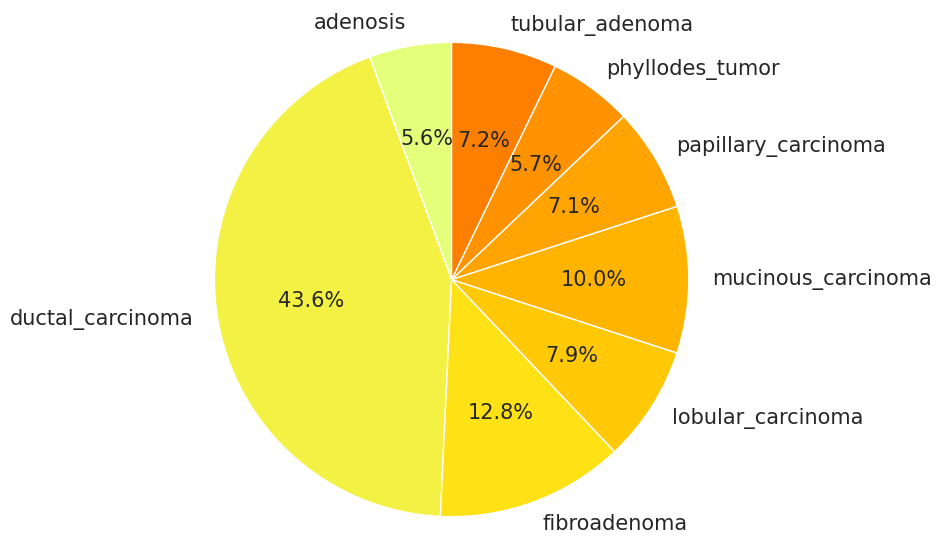

In [19]:
dataset.groupby(['sublabel']).size().plot(kind='pie', autopct="%.1f%%", figsize=(10,7), colormap='Wistia', startangle=90, textprops={'size': 'smaller'}, radius=1.1)
plt.savefig('Percentage_of_sublabels')

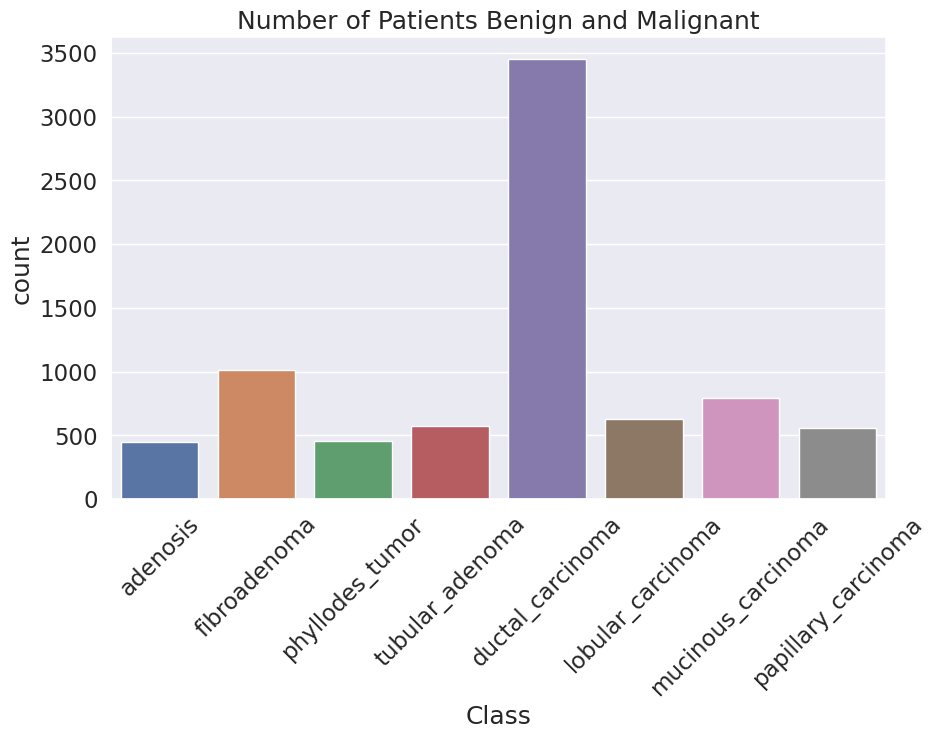

In [32]:
plt.figure(figsize=(10,6))
sns.set(font_scale=1.5)
sns.set_style("darkgrid")

# Assuming 'dataset' is your DataFrame
sns.countplot(data=dataset, x="sublabel")
plt.xlabel("Class")
plt.title("Number of Patients Benign and Malignant")
plt.xticks(rotation=45)
plt.show()

# Augumentation

In [33]:
dataset['sublabel'].value_counts()

sublabel
ductal_carcinoma       3451
fibroadenoma           1014
mucinous_carcinoma      792
lobular_carcinoma       626
tubular_adenoma         569
papillary_carcinoma     560
phyllodes_tumor         453
adenosis                444
Name: count, dtype: int64

In [34]:
sublabels = dataset['sublabel'].unique()

In [35]:
dataset_without_M_DC = dataset.loc[dataset['sublabel'] != 'ductal_carcinoma']

In [36]:
dataset_M_DC = dataset.loc[dataset['sublabel'] == 'ductal_carcinoma']

In [37]:
dataset_M_DC.shape

(3451, 9)

There are 3451 samples about Ductal Carcinoma, meanwhile, other subclasses just around 400 - 1000 samples. So I will divided it into 4 parts and just keep 1/4 data of DC samples.

In [38]:
dataset_M_DC.shape[0]/4

862.75

We will keep 863 samples of DC for Data balance. But we have four the difference zoom, X40, X100, X200, X400. So, we must divide it so balance

In [39]:
dataset_M_DC.shape[0]/16

215.6875

In each magnitude Zoom, we will keep 216 samples at all, we have 864 samples for DC

In [40]:
filter_data = list()
x100 = 0
x200=0
x400=0
x40=0

for index, row in dataset_M_DC.iterrows():
    filename = row['filename']
    if (filename.split('-')[3]=='40') and (x40<217):
        x40+=1
        filter_data.append(row)
    elif (filename.split('-')[3]=='200') and (x200<217):
        x200+=1
        filter_data.append(row)
    elif (filename.split('-')[3]=='100') and (x100<217):
        x100+=1
        filter_data.append(row)

    elif (filename.split('-')[3]=='400') and (x400<217):
        x400+=1
        filter_data.append(row)


In [41]:
new_dataset_M_DC = pd.DataFrame(filter_data)
new_dataset_M_DC.shape

(868, 9)

In [42]:
new_dataset = pd.concat([dataset_without_M_DC, new_dataset_M_DC], ignore_index=True)

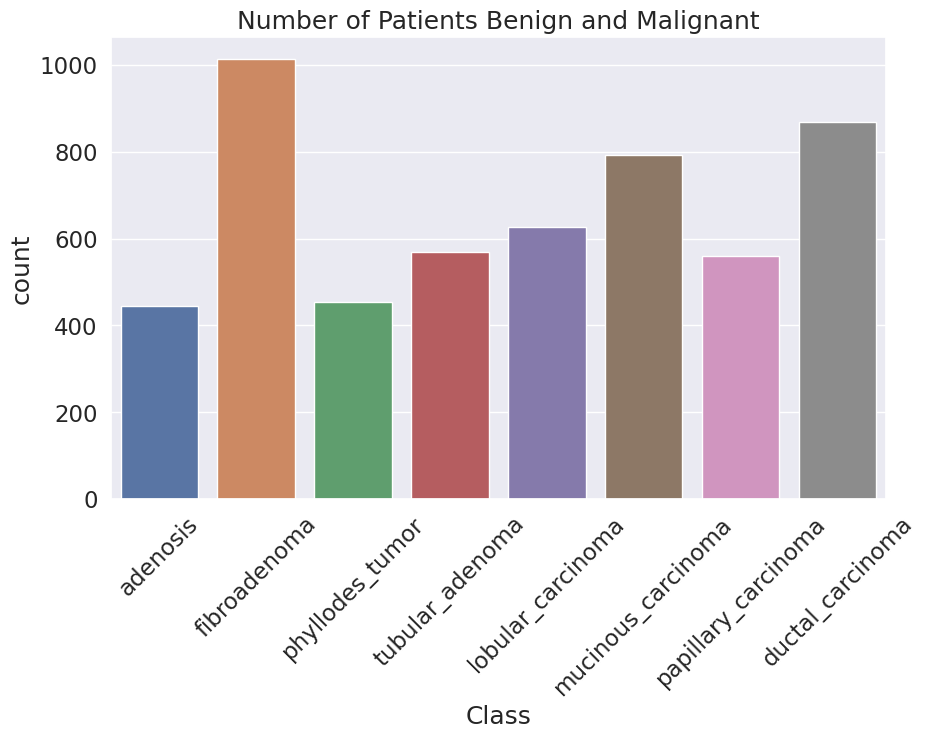

In [43]:
plt.figure(figsize=(10,6))
sns.set(font_scale=1.5)
sns.set_style("darkgrid")

# Assuming 'dataset' is your DataFrame
sns.countplot(data=new_dataset, x="sublabel")
plt.xlabel("Class")
plt.title("Number of Patients Benign and Malignant")
plt.xticks(rotation=45)
plt.show()

In [44]:
dataset = new_dataset

# Data Preprogressing

In [45]:
#Creating new directory
os.makedirs("/kaggle/working/Image_Dataset/")
#Creating new directory for benign
os.makedirs("/kaggle/working/Image_Dataset/Benign/")
#Creating new directory for malignant
os.makedirs("/kaggle/working/Image_Dataset/Malignant/")

In [46]:
#Moving all the images into one folder (Image_Dataset)
i = 0
for p in dataset['path']:
    src = "/kaggle/input/BreaKHis_v1/" + p
    dest = "/kaggle/working/Image_Dataset/"
    if dataset["class"][i] == 0:
        dest = "/kaggle/working/Image_Dataset/Benign/"
    else:
        dest = "/kaggle/working/Image_Dataset/Malignant/"
    #saving the files with its corresponding class and patient_id
    dest = os.path.join(dest,src.split("/")[7]+ "_" + src.split("/")[-1])
#     if src.split('/')[-2] == '400X':
#         shutil.copyfile(src,dest)
#         i +=1
    shutil.copyfile(src,dest)
    i +=1

In [47]:
train_datagen = ImageDataGenerator(rescale = 1./255)

In [48]:
train_path = './Image_Dataset'
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                              batch_size = BATCH_SIZE,
                                              class_mode = 'categorical',
                                              shuffle=True)

Found 5326 images belonging to 2 classes.


In [49]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(
    train_set.filenames,
    train_set.classes,
    test_size=0.2,
    random_state=42,
    stratify=train_set.classes
)

# Analysics the results

In [2]:
df_result = pd.read_csv('./data.csv')

In [3]:
df_result.head().max().reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   4 non-null      object 
 1   0       4 non-null      float64
dtypes: float64(1), object(1)
memory usage: 196.0+ bytes


In [4]:
start = 10
df_result['percent'] = [start + i * 5 for i in range(12)]

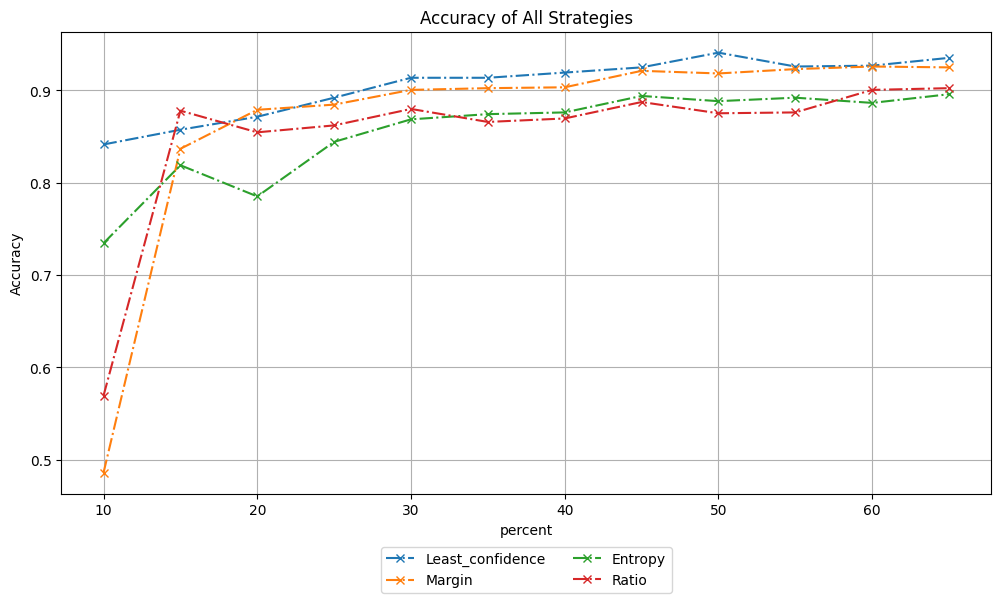

In [5]:
df_result.plot(figsize=(12,6), linestyle='dashdot', marker='x', x='percent', grid=True, ylabel="Accuracy", title="Accuracy of All Strategies")
# Set the position of the legend
legend_pos = (0.5, -0.1)  # Adjust the values as needed
# Move the legend below the plot
plt.legend(loc='upper center', bbox_to_anchor=legend_pos, ncol=2)
plt.savefig('./Charts/output.png', bbox_inches="tight")

In [6]:
df_result = df_result.iloc[:, :-1]

In [7]:
df_result['bottle neck'] = [0.9504 for i in range(12)]

In [8]:
df_first_5_step = df_result.iloc[:, :-1].head().max().reset_index()
model_acc = df_first_5_step[0].max()
model_name = df_first_5_step.loc[df_first_5_step[0] == model_acc]['index'].values[0]
value_index = df_result.loc[df_result.eq(model_acc).any(axis=1)].index[0] + 1 
print(f'Model {model_name} is high acc in 5 step at step {value_index}: ACC - {model_acc} with {(value_index - 1) * 5 + 10} % Data')

Model Least_confidence is high acc in 5 step at step 5: ACC - 0.9136960506439208 with 30 % Data


In [9]:
df_result

Least_confidence    Margin   Entropy     Ratio  bottle neck
0           0.841463  0.485929  0.734522  0.569418       0.9504
1           0.857411  0.836773  0.818949  0.878049       0.9504
2           0.871482  0.878987  0.785178  0.854597       0.9504
3           0.892120  0.884615  0.844278  0.862101       0.9504
4           0.913696  0.900563  0.868668  0.879925       0.9504
5           0.913696  0.902439  0.874296  0.865854       0.9504
6           0.919325  0.903377  0.876173  0.869606       0.9504
7           0.924953  0.921201  0.893996  0.887430       0.9504
8           0.940901  0.918387  0.888368  0.875235       0.9504
9           0.925891  0.923077  0.892120  0.876173       0.9504
10          0.926829  0.925891  0.886492  0.900563       0.9504
11          0.935272  0.924953  0.895872  0.902439       0.9504

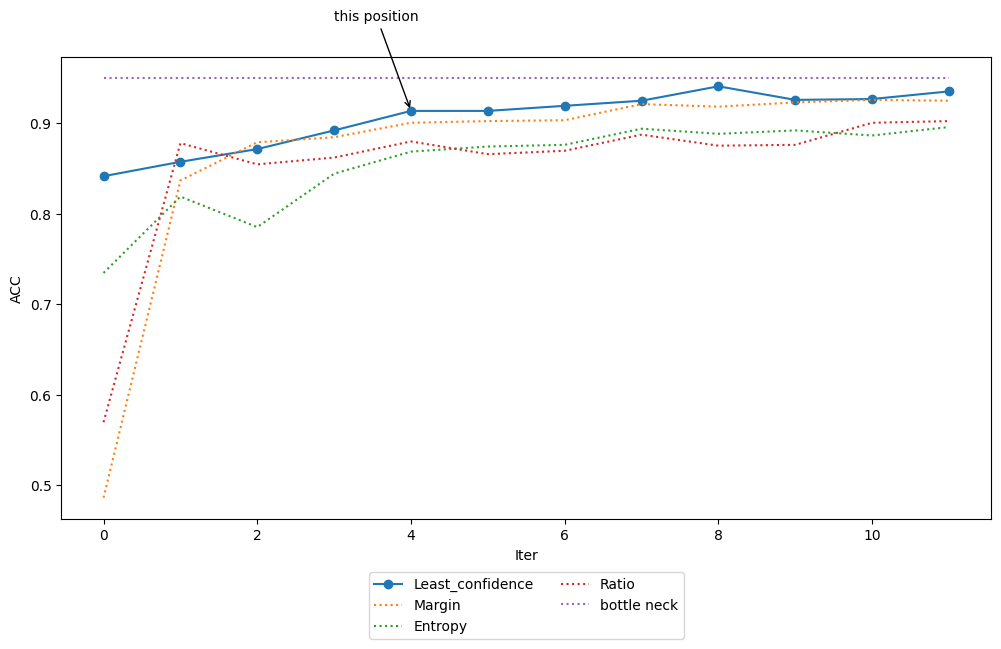

In [10]:
line_styles = ['solid' if name==model_name else 'dotted' for name in df_result.columns]
markers = ['o' if name==model_name else None for name in df_result.columns]

fig, ax = plt.subplots(figsize=(12, 6))
for i, column in enumerate(df_result.columns):
    ax.plot(df_result[column], linestyle=line_styles[i], label=column, marker=markers[i])
    if model_name == column:
        # Add an arrow at a specific point
        arrow_point_index = value_index - 1  # Specify the index of the point where you want to add the arrow
        arrow_point_x = df_result.index[arrow_point_index]  # Get the x-coordinate of the arrow point
        arrow_point_y = df_result[column].iloc[arrow_point_index]  # Get the y-coordinate of the arrow point
        ax.annotate('this position',
                    xy=(arrow_point_x, arrow_point_y),
                    xytext=(arrow_point_x - 1, arrow_point_y + 0.1),
                    arrowprops=dict(arrowstyle='->'))
# Set the position of the legend
legend_pos = (0.5, -0.1)  # Adjust the values as needed
# Move the legend below the plot
plt.legend(loc='upper center', bbox_to_anchor=legend_pos, ncol=2)
plt.xlabel('Iter')
plt.ylabel('ACC')
# Show the plot
plt.show()

#### Describe data on each step train AC

In [11]:
df_result = df_result.iloc[:,:-1]

In [12]:
df_result.T.describe()

0         1         2         3         4         5         6   \
count  4.000000  4.000000  4.000000  4.000000  4.000000  4.000000  4.000000   
mean   0.657833  0.847796  0.847561  0.870779  0.890713  0.889071  0.892120   
std    0.160176  0.025569  0.042821  0.021791  0.020229  0.022675  0.023295   
min    0.485929  0.818949  0.785178  0.844278  0.868668  0.865854  0.869606   
25%    0.548546  0.832317  0.837242  0.857645  0.877111  0.872186  0.874531   
50%    0.651970  0.847092  0.863039  0.873358  0.890244  0.888368  0.889775   
75%    0.761257  0.862570  0.873358  0.886492  0.903846  0.905253  0.907364   
max    0.841463  0.878049  0.878987  0.892120  0.913696  0.913696  0.919325   

             7         8         9         10        11  
count  4.000000  4.000000  4.000000  4.000000  4.000000  
mean   0.906895  0.905722  0.904315  0.909944  0.914634  
std    0.018939  0.029601  0.024209  0.019811  0.018557  
min    0.887430  0.875235  0.876173  0.886492  0.895872  
25%    0.892355  0.885084  0.888133  0.897045  0.900797  
50%    0.907598  0.903377  0.907598  0.913227  0.913696  
75%    0.922139  0.924015  0.923780  0.926126  0.927533  
max    0.924953  0.940901  0.925891  0.926829  0.935272

In [13]:
df_max_acc = df_result.T.max().loc[df_result.T.max().max() == df_result.T.max()]
print('The maximun Accuracy with we have are:')
print(df_max_acc)
first_index = int(df_max_acc.reset_index().iloc[0]['index'])
value_first_index = df_max_acc.reset_index().iloc[0][0]
print('The first epoch wit earn with acc:', first_index)
print(f'Index start with 0, the step is {first_index + 1}')
model_name = df_result.iloc[first_index].index[df_result.iloc[first_index].argmax()]
print(f'At step {first_index + 1} with {(first_index ) * 5 + 10} % data')

The maximun Accuracy with we have are:
8    0.940901
dtype: float64
The first epoch wit earn with acc: 8
Index start with 0, the step is 9
At step 9 with 50 % data


0.9136960506439208
4


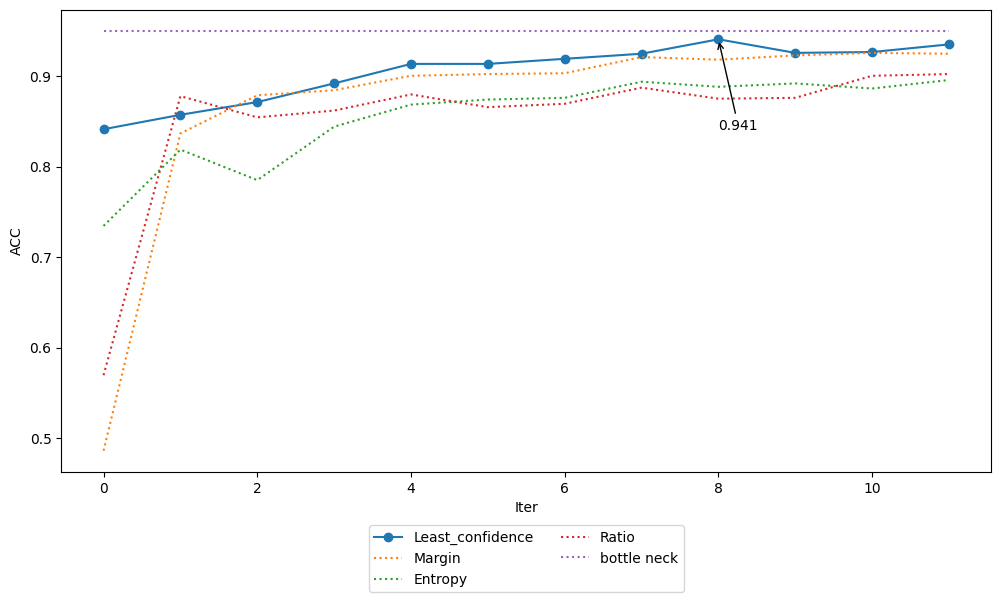

In [14]:
df_result['bottle neck'] = [0.9504 for i in range(12)]
line_styles = ['solid' if name==model_name else 'dotted' for name in df_result.columns]
markers = ['o' if name==model_name else None for name in df_result.columns]

fig, ax = plt.subplots(figsize=(12, 6))
for i, column in enumerate(df_result.columns):
    ax.plot(df_result[column], linestyle=line_styles[i], label=column, marker=markers[i])
    if model_name == column:
        # Add an arrow at a specific point
        print(arrow_point_y)
        print(arrow_point_x)
        arrow_point_index = first_index  # Specify the index of the point where you want to add the arrow
        arrow_point_x = df_result.index[arrow_point_index]  # Get the x-coordinate of the arrow point
        arrow_point_y = df_result[column].iloc[arrow_point_index]  # Get the y-coordinate of the arrow point
        ax.annotate(round(value_first_index, 3),
                    xy=(arrow_point_x, arrow_point_y),
                    xytext=(arrow_point_x, arrow_point_y - 0.1),
                    arrowprops=dict(arrowstyle='->'))
# Set the position of the legend
legend_pos = (0.5, -0.1)  # Adjust the values as needed
# Move the legend below the plot
plt.legend(loc='upper center', bbox_to_anchor=legend_pos, ncol=2)
plt.xlabel('Iter')
plt.ylabel('ACC')
# Show the plot
plt.show()

In [15]:
df_result = df_result.iloc[:,:-1]

In [16]:
first_high = dict()
for column in df_result.columns:
    first_high[column] = df_result[column].argmax() + 1
    

In [17]:
first_high

{'Least_confidence': 9, 'Margin': 11, 'Entropy': 12, 'Ratio': 12}

# ReClaim Model

In [50]:
class My_Custom_Generator(keras.utils.Sequence):

  def __init__(self, image_filenames, labels, directory, batch_size):
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.directory = directory

  def __len__(self):
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)

  def __getitem__(self, idx):
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    data = np.array([
            image.img_to_array(image.load_img(os.path.join(self.directory, file_name), target_size=(256, 256)))
               for file_name in batch_x])/255.0

    return (data, np.array(batch_y))

  def generator(self):
    for idx in range(len(self)):
      yield self.__getitem__(idx)

  def get_dataset(self):
    output_signature = (
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )

    return tf.data.Dataset.from_generator(
        self.__getitem__,
        output_signature=output_signature
    )

In [51]:
my_train_batch_generator = My_Custom_Generator(train_images, train_labels, train_path, 32)
my_test_batch_generator = My_Custom_Generator(test_images, test_labels, train_path, 32)

In [52]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
inputs_shape = Input(shape=input_shape)

In [53]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4, restore_best_weights=True)

In [55]:
def eval_prioritization_strategy(prioritizer, x_train, y_train, epoch=12):
    train_indices = range(len(x_train))
    NUM_SAMPLE = round(len(x_train) * 0.05)
    print(NUM_SAMPLE)
    START_SAMPLE = round(len(x_train) * 0.1)
    test_accuracies = []
    x_train_subset = np.zeros([0,])
    y_train_subset = np.empty([0,])
    inception_model = ResNet152V2(
        weights="imagenet",
        input_tensor=inputs_shape,
        input_shape=(256, 256, 3),
        include_top=False
    )
    for layer in inception_model.layers[:140]:
        layer.trainable = False
    for i in range(epoch):
        if i == 0:
            selected_indices = train_indices[0:START_SAMPLE]
            train_indices = train_indices[START_SAMPLE:]
        else:
            selected_indices = train_indices[0:NUM_SAMPLE]
            train_indices = train_indices[NUM_SAMPLE:]
        x_train_subset = np.concatenate((x_train_subset, x_train[selected_indices,...]))
        y_train_subset = np.concatenate((y_train_subset, y_train[selected_indices,...]))
        my_train_batch_generator = My_Custom_Generator(x_train_subset, y_train_subset, train_path, 32)
        my_predict_batch_generator = My_Custom_Generator(x_train[train_indices,...], y_train[train_indices,...], train_path, 32)
        x3 = inception_model.output
        x3 = tf.keras.layers.GlobalAveragePooling2D()(x3)
        x3 = Dense(512, activation = "relu")(x3)
        x3 = tf.keras.layers.Dropout(0.2)(x3)
        x3 = tf.keras.layers.Dense(256, activation='relu')(x3)   # pass the merged tensor to the Dense layer, not the Concatenate layer output
        d1 = tf.keras.layers.Dropout(0.2)(x3)
        h2 = tf.keras.layers.Dense(128, activation = "relu")(x3)
        d2 = tf.keras.layers.Dropout(0.2)(h2)

        output = tf.keras.layers.Dense(1, activation='sigmoid')(d2)

        model = tf.keras.Model(inputs=inputs_shape, outputs=output)

        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(my_train_batch_generator, epochs=20, verbose=0, callbacks=[early_stopping])
        loss, accuracy = model.evaluate(my_test_batch_generator, verbose=1)
        test_accuracies.append(accuracy)
        print('Training data size of %d => accuracy %f' % (x_train_subset.shape[0], accuracy))

        predictions = model.predict(my_predict_batch_generator)
        train_indices = prioritizer(train_indices, predictions)

    return test_accuracies, model


In [50]:
def least_confidence_prediction_prioritizer(indices, predictions):
    max_logit = list(zip(indices, np.amax(np.abs(np.array(predictions) - 0.5) + 0.5,axis=1)))
    max_logit.sort(key=lambda x: x[1]) # sort in ascending order
    return list(zip(*max_logit))[0]
#     return list(zip(*max_logit))

In [ ]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [58]:
accuracy, model = eval_prioritization_strategy(least_confidence_prediction_prioritizer, train_images, train_labels, epoch=first_high['Least_confidence'])

213


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1710891754.326021     249 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 498ms/step - accuracy: 0.8289 - loss: 2.4473
Training data size of 426 => accuracy 0.841463
120/120 ━━━━━━━━━━━━━━━━━━━━ 68s 488ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 476ms/step - accuracy: 0.8387 - loss: 3.0006
Training data size of 639 => accuracy 0.857411
114/114 ━━━━━━━━━━━━━━━━━━━━ 62s 470ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 482ms/step - accuracy: 0.8563 - loss: 1.9563
Training data size of 852 => accuracy 0.871482
107/107 ━━━━━━━━━━━━━━━━━━━━ 61s 491ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 487ms/step - accuracy: 0.8748 - loss: 1.2765
Training data size of 1065 => accuracy 0.892120
100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 514ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 491ms/step - accuracy: 0.9003 - loss: 0.9084
Training data size of 1278 => accuracy 0.913696
94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 492ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 497ms/step - accuracy: 0.9016 - loss: 1.5152
Training data size of 1491 => accuracy 0.913696
87/87 ━━━━━━━━━━━━━━━━━━━━ 55s 530ms/step

In [55]:
loss, accuracy = model.evaluate(my_test_batch_generator, verbose=1)
predictions = model.predict(my_test_batch_generator)

34/34 ━━━━━━━━━━━━━━━━━━━━ 29s 577ms/step - accuracy: 0.9536 - loss: 0.2222
34/34 ━━━━━━━━━━━━━━━━━━━━ 32s 637ms/step


In [57]:
y_preds = np.array([round(item[0]) for item in predictions])

In [62]:
class_names = train_set.class_indices.keys()

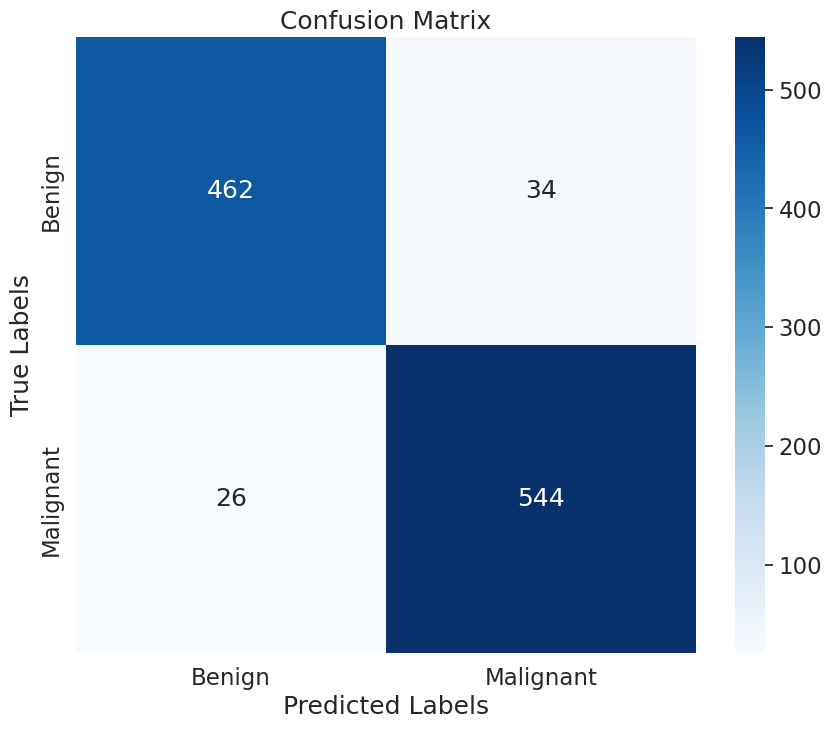

              precision    recall  f1-score   support

      Benign       0.95      0.93      0.94       496
   Malignant       0.94      0.95      0.95       570

    accuracy                           0.94      1066
   macro avg       0.94      0.94      0.94      1066
weighted avg       0.94      0.94      0.94      1066



In [71]:
cm = confusion_matrix(test_labels, y_preds)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('Confusion Matrix')
plt.show()

# Generate the classification report
report = classification_report(test_labels, y_preds, target_names=class_names)

# Print the classification report
print(report)

# Thank you